# The Larry David Identifier

 Larry David was by far the show's most prolific writer, credited on a third of the total episodes produced. By using a a Keras Deep Learning Model with Natural Language Processing can we tease out Larry David's signature in the dialogue of Seinfeld?

<img src='https://media.giphy.com/media/3ohhwBgENXNtIImU3m/giphy.gif'>

In [38]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model ,Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!matplotlib inline
np.random.seed(0)

'matplotlib' is not recognized as an internal or external command,
operable program or batch file.


Cleaned and modified tables are imported to dataframes

In [39]:
episodes=pd.read_csv('episodes_cleaned.csv',index_col='Unnamed: 0')
scripts=pd.read_csv('scripts_cleaned.csv',index_col='Unnamed: 0')

Episodes are labelled by whether 'Larry David' was in the writing credits.

In [40]:
episodes['Larry']=0
for ep in episodes.iterrows():
    names=(ep[1][4].replace(' and ',',').split(','))
    for name in names:
        if 'Larry David' in name:
            episodes['Larry'][ep[0]]=1
larry_eps=list(episodes.loc[episodes.Larry==1]['SEID'])
    

C:\Users\kosta\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


The scripts rows are also labelled based on the SEID whether Larry David was credited on that episode

In [44]:
scripts['Larry']=0
for ep in larry_eps:
    scripts.loc[scripts['SEID']==ep,'Larry']=1
scripts[['Dialogue','character_stripped','Larry']].head()

,Dialogue,character_stripped,Larry
0,do you know what this is all about? do you kno...,jerry,1
1,"(pointing at georges shirt) see, to me, that b...",jerry,1
2,are you through?,george,1
3,"you do of course try on, when you buy?",jerry,1
4,"yes, it was purple, i liked it, i dont actuall...",george,1


The individual snippets of dialogue are tokenized and converted to uniform length padded sequences

In [6]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(scripts['Dialogue'].values))
list_tokenized_train = tokenizer.texts_to_sequences(scripts.Dialogue.values)
X_t = pad_sequences(list_tokenized_train,maxlen=100)
y=scripts.Larry.values

To address the data imbalance, the dataset is resampled using Synthetic Minority Oversampling TEchnique to give an even distribution

In [7]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_t, y) 

Dataset is split into train and test sets, the testing set will comprise 25% of the data. 

In [8]:
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_resampled,y_resampled)

# Keras Deep Learning Models

An iterative approach is it taken to model constuction. Each model starts with an Embedding layer and outputs to a single Densely connected node with sigmoid activation. Models are fit for 4 or 5 epochs with batch size of 32 and validation split of 0.1. The lowest validation loss generally occurs after the second epoch and the saved model will reflect this optimization.

Long Short Term Memory (50 nodes) and Dropout (0.5)

In [27]:
lstm_model = Sequential()
lstm_model.add(Embedding(20000,128))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'lstm_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

lstm_history=lstm_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 236s 5ms/step - loss: 0.6663 - acc: 0.5794 - val_loss: 0.6178 - val_acc: 0.6375

Epoch 00001: val_loss improved from inf to 0.61776, saving model to lstm_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 236s 5ms/step - loss: 0.5542 - acc: 0.6999 - val_loss: 0.5923 - val_acc: 0.6606

Epoch 00002: val_loss improved from 0.61776 to 0.59230, saving model to lstm_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 228s 5ms/step - loss: 0.4653 - acc: 0.7544 - val_loss: 0.6210 - val_acc: 0.6588

Epoch 00003: val_loss did not improve from 0.59230
Epoch 4/5
48714/48714 [==============================] - 225s 5ms/step - loss: 0.4080 - acc: 0.7840 - val_loss: 0.6628 - val_acc: 0.6723

Epoch 00004: val_loss did not improve from 0.59230
Epoch 5/5
48714/48714 [==============================] - 225s 5ms/step - loss: 0.3704 - acc: 0.8015 -

Bidirectional Long Short Term Memory (50 nodes) and Dropout (0.5)

In [31]:
lstm_bi_model = Sequential()
lstm_bi_model.add(Embedding(20000,128))
lstm_bi_model.add(Bidirectional(LSTM(50, return_sequences=True)))
lstm_bi_model.add(GlobalMaxPool1D())
lstm_bi_model.add(Dropout(0.5))
lstm_bi_model.add(Dense(1, activation='sigmoid'))

lstm_bi_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'lstm_bi_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

lstm_bi_history=lstm_bi_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 392s 8ms/step - loss: 0.6581 - acc: 0.5932 - val_loss: 0.6080 - val_acc: 0.6477

Epoch 00001: val_loss improved from inf to 0.60798, saving model to lstm_bi_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 389s 8ms/step - loss: 0.5342 - acc: 0.7170 - val_loss: 0.5997 - val_acc: 0.6651

Epoch 00002: val_loss improved from 0.60798 to 0.59973, saving model to lstm_bi_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 367s 8ms/step - loss: 0.4426 - acc: 0.7685 - val_loss: 0.6212 - val_acc: 0.6662

Epoch 00003: val_loss did not improve from 0.59973
Epoch 4/5
48714/48714 [==============================] - 376s 8ms/step - loss: 0.3860 - acc: 0.7963 - val_loss: 0.6912 - val_acc: 0.6656

Epoch 00004: val_loss did not improve from 0.59973
Epoch 5/5
48714/48714 [==============================] - 355s 7ms/step - loss: 0.3453 - acc: 0.

Gated Recurrent Unit (50 nodes) and Dropout (0.5)

In [28]:
gru_model = Sequential()
gru_model.add(Embedding(20000,128))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(GlobalMaxPool1D())
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_history=gru_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 199s 4ms/step - loss: 0.6625 - acc: 0.5855 - val_loss: 0.6139 - val_acc: 0.6447

Epoch 00001: val_loss improved from inf to 0.61387, saving model to gru_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 195s 4ms/step - loss: 0.5442 - acc: 0.7084 - val_loss: 0.5835 - val_acc: 0.6693

Epoch 00002: val_loss improved from 0.61387 to 0.58347, saving model to gru_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 205s 4ms/step - loss: 0.4491 - acc: 0.7660 - val_loss: 0.6024 - val_acc: 0.6789

Epoch 00003: val_loss did not improve from 0.58347
Epoch 4/5
48714/48714 [==============================] - 218s 4ms/step - loss: 0.3906 - acc: 0.7968 - val_loss: 0.6301 - val_acc: 0.6675

Epoch 00004: val_loss did not improve from 0.58347
Epoch 5/5
48714/48714 [==============================] - 227s 5ms/step - loss: 0.3507 - acc: 0.8155 - v

Bidirectional Gated Recurrent Unit (50 nodes) and Dropout (0.5)

In [28]:
gru_bi_model = Sequential()
gru_bi_model.add(Embedding(20000,128))
gru_bi_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi_model.add(GlobalMaxPool1D())
gru_bi_model.add(Dropout(0.5))
gru_bi_model.add(Dense(1, activation='sigmoid'))

gru_bi_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi_history=gru_bi_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 168s 3ms/step - loss: 0.6522 - acc: 0.6048 - val_loss: 0.5934 - val_acc: 0.6710

Epoch 00001: val_loss improved from inf to 0.59343, saving model to gru_bi_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 170s 3ms/step - loss: 0.5261 - acc: 0.7242 - val_loss: 0.5585 - val_acc: 0.6928

Epoch 00002: val_loss improved from 0.59343 to 0.55855, saving model to gru_bi_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 172s 4ms/step - loss: 0.4326 - acc: 0.7752 - val_loss: 0.5835 - val_acc: 0.6946

Epoch 00003: val_loss did not improve from 0.55855
Epoch 4/5
48714/48714 [==============================] - 171s 4ms/step - loss: 0.3700 - acc: 0.8060 - val_loss: 0.6199 - val_acc: 0.6885

Epoch 00004: val_loss did not improve from 0.55855
Epoch 5/5
48714/48714 [==============================] - 169s 3ms/step - loss: 0.3274 - acc: 0.82

Bidirectional GRU is the best of these shallow tests, further testing will be done on larger, deeper models.

Bidirectional Gated Recurrent Unit (50 nodes) and Dense layer (50 nodes)

In [35]:
gru_bi2_model = Sequential()
gru_bi2_model.add(Embedding(20000,128))
gru_bi2_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi2_model.add(GlobalMaxPool1D())
gru_bi2_model.add(Dense(50,activation='relu'))
gru_bi2_model.add(Dense(1, activation='sigmoid'))

gru_bi2_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi2_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi2_history=gru_bi2_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 313s 6ms/step - loss: 0.6409 - acc: 0.6096 - val_loss: 0.5868 - val_acc: 0.6688

Epoch 00001: val_loss improved from inf to 0.58677, saving model to gru_bi2_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 314s 6ms/step - loss: 0.4915 - acc: 0.7423 - val_loss: 0.5794 - val_acc: 0.6762

Epoch 00002: val_loss improved from 0.58677 to 0.57943, saving model to gru_bi2_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 295s 6ms/step - loss: 0.3845 - acc: 0.8023 - val_loss: 0.6614 - val_acc: 0.6715

Epoch 00003: val_loss did not improve from 0.57943
Epoch 4/5
48714/48714 [==============================] - 322s 7ms/step - loss: 0.3186 - acc: 0.8316 - val_loss: 0.7555 - val_acc: 0.6680

Epoch 00004: val_loss did not improve from 0.57943
Epoch 5/5
48714/48714 [==============================] - 317s 7ms/step - loss: 0.2722 - acc: 0.

Bidirectional Gated Recurrent Unit (50 nodes) and Dense layer (50 nodes) and dropout (0.2)

In [36]:
gru_bi2d_model = Sequential()
gru_bi2d_model.add(Embedding(20000,128))
gru_bi2d_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi2d_model.add(GlobalMaxPool1D())
gru_bi2d_model.add(Dense(50,activation='relu'))
gru_bi2d_model.add(Dropout(0.2))
gru_bi2d_model.add(Dense(1, activation='sigmoid'))

gru_bi2d_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi2d_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi2d_history=gru_bi2d_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 299s 6ms/step - loss: 0.6444 - acc: 0.6105 - val_loss: 0.5961 - val_acc: 0.6608

Epoch 00001: val_loss improved from inf to 0.59606, saving model to gru_bi2d_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 305s 6ms/step - loss: 0.5011 - acc: 0.7373 - val_loss: 0.5708 - val_acc: 0.6828

Epoch 00002: val_loss improved from 0.59606 to 0.57078, saving model to gru_bi2d_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 298s 6ms/step - loss: 0.3962 - acc: 0.7944 - val_loss: 0.6305 - val_acc: 0.6763

Epoch 00003: val_loss did not improve from 0.57078
Epoch 4/4
48714/48714 [==============================] - 300s 6ms/step - loss: 0.3273 - acc: 0.8258 - val_loss: 0.6768 - val_acc: 0.6854

Epoch 00004: val_loss did not improve from 0.57078


In [ ]:
Bidirectional Gated Recurrent Unit (100 nodes) and two Dense layers (100 & 50 nodes) and dropout (0.2)

In [37]:
gru_bi2d_model = Sequential()
gru_bi2d_model.add(Embedding(20000,128))
gru_bi2d_model.add(Bidirectional(GRU(100, return_sequences=True)))
gru_bi2d_model.add(GlobalMaxPool1D())
gru_bi2d_model.add(Dense(100,activation='relu'))
gru_bi2d_model.add(Dropout(0.2))
gru_bi2d_model.add(Dense(50,activation='relu'))
gru_bi2d_model.add(Dropout(0.2))
gru_bi2d_model.add(Dense(1, activation='sigmoid'))

gru_bi2d_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi2d_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi2d_history=gru_bi2d_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 448s 9ms/step - loss: 0.6459 - acc: 0.6075 - val_loss: 0.5831 - val_acc: 0.6762

Epoch 00001: val_loss improved from inf to 0.58311, saving model to gru_bi2d_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 412s 8ms/step - loss: 0.5007 - acc: 0.7354 - val_loss: 0.5849 - val_acc: 0.6887

Epoch 00002: val_loss did not improve from 0.58311
Epoch 3/4
48714/48714 [==============================] - 393s 8ms/step - loss: 0.3957 - acc: 0.7911 - val_loss: 0.6475 - val_acc: 0.6786

Epoch 00003: val_loss did not improve from 0.58311
Epoch 4/4
48714/48714 [==============================] - 400s 8ms/step - loss: 0.3269 - acc: 0.8251 - val_loss: 0.7372 - val_acc: 0.6852

Epoch 00004: val_loss did not improve from 0.58311


## Best Model
Bidirectional Gated Recurrent Unit (200 nodes) and three Dense layers (200, 100, 50 nodes) and dropout (0.2)

In [30]:
gru_3l_bi2d_model = Sequential()
gru_3l_bi2d_model.add(Embedding(20000,128))
gru_3l_bi2d_model.add(Bidirectional(GRU(200, return_sequences=True)))
gru_3l_bi2d_model.add(GlobalMaxPool1D())
gru_3l_bi2d_model.add(Dense(200,activation='relu'))
gru_3l_bi2d_model.add(Dropout(0.2))
gru_3l_bi2d_model.add(Dense(100,activation='relu'))
gru_3l_bi2d_model.add(Dropout(0.2))
gru_3l_bi2d_model.add(Dense(50,activation='relu'))
gru_3l_bi2d_model.add(Dropout(0.2))
gru_3l_bi2d_model.add(Dense(1, activation='sigmoid'))

gru_3l_bi2d_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_3l_bi2d_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_3l_bi2d_history=gru_3l_bi2d_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 309s 6ms/step - loss: 0.6648 - acc: 0.5820 - val_loss: 0.6078 - val_acc: 0.6508

Epoch 00001: val_loss improved from inf to 0.60777, saving model to gru_3l_bi2d_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 306s 6ms/step - loss: 0.5241 - acc: 0.7221 - val_loss: 0.5452 - val_acc: 0.7046

Epoch 00002: val_loss improved from 0.60777 to 0.54521, saving model to gru_3l_bi2d_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 301s 6ms/step - loss: 0.4153 - acc: 0.7839 - val_loss: 0.5863 - val_acc: 0.6983

Epoch 00003: val_loss did not improve from 0.54521
Epoch 4/4
48714/48714 [==============================] - 331s 7ms/step - loss: 0.3455 - acc: 0.8162 - val_loss: 0.6134 - val_acc: 0.6893

Epoch 00004: val_loss did not improve from 0.54521


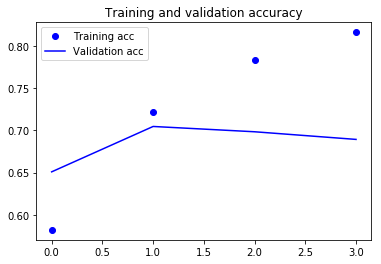

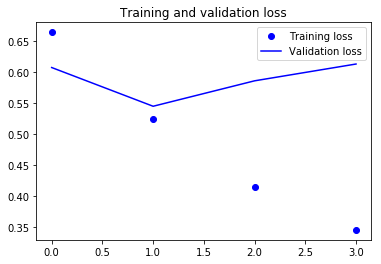

In [31]:
acc = gru_3l_bi2d_history.history['acc']
val_acc = gru_3l_bi2d_history.history['val_acc']
loss = gru_3l_bi2d_history.history['loss']
val_loss = gru_3l_bi2d_history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Further training after the second epoch continues to improve the training loss and accuracy but has a detrimental effect on the validation loss and accuracy. After the second epoch the model is being <b>overfit</b> to training data.

Further attemps to  improve the validation loss by increasing the Dropout rate and by including L1 regularization loss were not successful.

Bidirectional Gated Recurrent Unit (200 nodes) and three Dense layers (200, 100, 50 nodes) and dropout (0.5)

In [44]:
gru_3l_bi2d5_model = Sequential()
gru_3l_bi2d5_model.add(Embedding(20000,128))
gru_3l_bi2d5_model.add(Bidirectional(GRU(200, return_sequences=True)))
gru_3l_bi2d5_model.add(GlobalMaxPool1D())
gru_3l_bi2d5_model.add(Dense(200,activation='relu'))
gru_3l_bi2d5_model.add(Dropout(0.5))
gru_3l_bi2d5_model.add(Dense(100,activation='relu'))
gru_3l_bi2d5_model.add(Dropout(0.5))
gru_3l_bi2d5_model.add(Dense(50,activation='relu'))
gru_3l_bi2d5_model.add(Dropout(0.5))
gru_3l_bi2d5_model.add(Dense(1, activation='sigmoid'))

gru_3l_bi2d5_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_3l_bi2d5_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_3l_bi2d5_history=gru_3l_bi2d5_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 765s 16ms/step - loss: 0.6922 - acc: 0.5249 - val_loss: 0.6782 - val_acc: 0.5930

Epoch 00001: val_loss improved from inf to 0.67824, saving model to gru_3l_bi2d5_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 751s 15ms/step - loss: 0.6113 - acc: 0.6627 - val_loss: 0.5802 - val_acc: 0.6773

Epoch 00002: val_loss improved from 0.67824 to 0.58018, saving model to gru_3l_bi2d5_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 779s 16ms/step - loss: 0.4849 - acc: 0.7518 - val_loss: 0.5824 - val_acc: 0.6835

Epoch 00003: val_loss did not improve from 0.58018
Epoch 4/4
48714/48714 [==============================] - 783s 16ms/step - loss: 0.3999 - acc: 0.7940 - val_loss: 0.6566 - val_acc: 0.6717

Epoch 00004: val_loss did not improve from 0.58018


Bidirectional Gated Recurrent Unit (50 nodes) and Dense layer (50 nodes) and l1 regularization (0.005)

In [39]:
gru_bi_l1_model = Sequential()
gru_bi_l1_model.add(Embedding(20000,128))
gru_bi_l1_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi_l1_model.add(GlobalMaxPool1D())
gru_bi_l1_model.add(Dense(50,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_bi_l1_model.add(Dense(1, activation='sigmoid'))

gru_bi_l1_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi_l1_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi_l1_history=gru_bi_l1_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 350s 7ms/step - loss: 0.8098 - acc: 0.5010 - val_loss: 0.6960 - val_acc: 0.5138

Epoch 00001: val_loss improved from inf to 0.69602, saving model to gru_bi_l1_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 450s 9ms/step - loss: 0.6961 - acc: 0.4954 - val_loss: 0.6960 - val_acc: 0.5138

Epoch 00002: val_loss improved from 0.69602 to 0.69602, saving model to gru_bi_l1_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 449s 9ms/step - loss: 0.6961 - acc: 0.4997 - val_loss: 0.6959 - val_acc: 0.5138

Epoch 00003: val_loss improved from 0.69602 to 0.69593, saving model to gru_bi_l1_weights_base.best.hdf5
Epoch 4/4
48714/48714 [==============================] - 363s 7ms/step - loss: 0.6961 - acc: 0.5009 - val_loss: 0.6961 - val_acc: 0.4862

Epoch 00004: val_loss did not improve from 0.69593


Bidirectional Gated Recurrent Unit (200 nodes) and three Dense layers (200, 100, 50 nodes) and l1 regularization (0.005)

In [ ]:
gru_3l1_bi_model = Sequential()
gru_3l1_bi_model.add(Embedding(20000,128))
gru_3l1_bi_model.add(Bidirectional(GRU(200, return_sequences=True)))
gru_3l1_bi_model.add(GlobalMaxPool1D())
gru_3l1_bi_model.add(Dense(200,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi_model.add(Dense(100,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi_model.add(Dense(50,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi_model.add(Dense(1, activation='sigmoid'))

gru_3l1_bi_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_3l1_bi_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_3l1_bi_history=gru_3l1_bi_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 979s 20ms/step - loss: 1.5565 - acc: 0.4964 - val_loss: 0.7584 - val_acc: 0.5138

Epoch 00001: val_loss improved from inf to 0.75835, saving model to gru_3l1_bi_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 1007s 21ms/step - loss: 0.7588 - acc: 0.5029 - val_loss: 0.7589 - val_acc: 0.5138

Epoch 00002: val_loss did not improve from 0.75835
Epoch 3/4
 1472/48714 [..............................] - ETA: 20:24 - loss: 0.7588 - acc: 0.4993

# Reload Best Model
The later adaptations fail to produce any improvements. The best model has been reloaded for evaluation on the test sample.
Bidirectional Gated Recurrent Unit (200 nodes) and three Dense layers (200, 100, 50 nodes) and dropout (0.2) trained for 2 epochs

In [32]:
model=keras.models.load_model('gru_3l_bi2d_weights_base.best.hdf5')

In [33]:
model.evaluate(X_r_test,y_r_test,batch_size=32)

18043/18043 [==============================] - 21s 1ms/step


[0.5557038038795608, 0.6966136451677427]

Model is ~70% accurate on testing data with a loss function of 0.56

In [34]:
y_predict=model.predict_classes(X_r_test,batch_size=32)

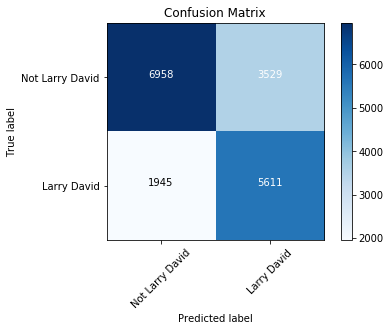

In [35]:
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_predict, y_r_test) #create confusion matrix

plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Not Larry David','Larry David'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()

In [36]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
print('Model Peformance Metrics:')
print('Precision: {}'.format(precision_score(y_r_test, y_predict)))
print('Recall: {}'.format(recall_score(y_r_test, y_predict)))
print('Accuracy: {}'.format(accuracy_score(y_r_test, y_predict)))
print('F1-Score: {}'.format(f1_score(y_r_test, y_predict)))

Model Peformance Metrics:
Precision: 0.7425886712546321
Recall: 0.6138949671772429
Accuracy: 0.6966136451809566
F1-Score: 0.6721370388116915


# The Conclusions
The model is successful at determining the whether or not the writer of the dialogue was Larry David. There is, however, room for improvement

# Future Work
1. More data could potentially be obtained from other shows that Larry David has written for such as Saturday Night Live or Curb Your Enthusiasm.
2. Short, simple phrases such as basic greetings could be eliminated from the dataset. Overly simple language is unlikely to have much distinctiveness to it, by using only longer dialogue lines the model is not stumped by a 'hello' that could be written by anyone. This, however, would result in less data to train the model on.
3. Using whole episodes as text corpora for a deeper Larry David understanding. 
4. Making use of the Character speaking as a training feature. Only the text of the dialogue is considered in this model but the stylistic nuances of Larry David are most likely unique to the character being written for


# Business Recommendations

## The Brand
'Seinfeld' is global brand, [From Elasticity](https://goelastic.com/three-immutable-branding-lessons-that-seinfeld-taught-us/)
>Seinfeld still runs on 90 percent of TV markets across the country and ranks among American adults’ top five favorite shows. It’s earned more than $3 billion (with a “b”) after its network run ended. And every weeknight, no fewer than one million people tune in to watch reruns.


This year there have been multiple 30th anniversary celebrations and shows such as the ['Seinfeld Experience'](https://deadline.com/2019/06/seinfeld-experience-sets-real-and-spectacular-opening-this-fall-in-new-york-1202638328/) 
>Part retail shop and part immersive show promotion, the ticketed attraction in the city’s Gramercy neighborhood will operate seven days a week. Tickets through February 2020<br>
>(Deadline.com)

There is huge scope for machine learning based products to utilize the Seinfeld name and brand. This notebook will introduce a learning model based on the identifying the writing of Larry David. This basic idea can be extrapolated and built from to create numerous writing and language based tie ins to the Seinfeld brand. For instance a "write like Larry David" teaching tool fro aspiring sit-com writers or a Seinfeld based adventure game.    

## The Fraud Prevention
Beyond Seinfeld, this type of application can be generalized to the field of fraud prevention. Training a deep learning model on writing samples from an individual the same way that has been done here could be used as part of a fraud prevention device designed to detect imposters in things like business and email correspondence

### The CEO Fraud
CEO fraud is a perfect candidate for this kind of implementation. 
>CEO Fraud is a scam in which cybercriminals spoof company email accounts and impersonate executives to try and fool an employee in accounting or HR into executing unauthorized wire transfers, or sending out confidential tax information.<br>
[source](https://www.knowbe4.com/ceo-fraud)

The FBI estimated the cost of impersonation fraud in the US alone at over $12 Billion in 2018 ([source](https://www.ic3.gov/media/2018/180712.aspx)) and this kind of scam is only becoming increasingly prevalent at an alarming rate:
> ...impersonation attacks increased almost 70 percent (67%) in comparison to the results in last year’s report – with 73 percent of those organizations impacted by impersonation attacks having experienced a direct loss.<br>
[source](https://www.globenewswire.com/news-release/2019/05/29/1854599/0/en/Mimecast-Global-Research-Finds-Loss-of-Customers-Finances-and-Data-Due-to-Rise-in-Impersonation-Attacks.html)

By training a similar model to the one above on business correspondence provided by the company, the writing styles of C-Level executives could be identified and tool created that would flag correspondence by potential impersonators for further scrutiny.

